In [26]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Flatten
from keras.layers import Embedding

In [27]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [28]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [29]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [30]:
# !ls drive/Project/Transparency\ Text\ Classification

# import os
# os.chdir('./drive/Colab Notebooks/text-classification-transparency')

In [31]:
# !ls

In [32]:
import numpy as np

seed = 42
np.random.seed(seed)

In [33]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [36]:
# Load data

def load_list(filename):
    vocabulary = []
    with open(filename, 'r') as f:
        for l in f:
            vocabulary.append(l.strip())
    return np.asarray(vocabulary)

def load_csv(filename):
    import csv
    
    sentence = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sentence.append(str(row))
    return np.asarray(sentence).flatten()

def generate_token_sequence(X_corpus, word_dict, token):
    import re

    token_pattern = re.compile(token)
    X = []
    i=0
    for sentence in X_corpus:
        split = token_pattern.findall(sentence)
        seq = []
        for word in split:
            try:
                seq.append(word_dict[word])
            except KeyError:
                continue
        X.append(seq)

    return np.asarray(X) 

In [50]:
import numpy as np
  
# print('load data...')
# pos_related = load_csv('pos_related.csv')
# neg_related = load_csv('neg_related.csv')
# pos_unrelated = load_csv('pos_unrelated.csv')
# neg_unrelated = load_csv('neg_unrelated.csv')
  
# print(pos_related.shape)
# print(neg_related.shape)
# print(pos_unrelated.shape)
# print(neg_unrelated.shape)
  
# print('Stack the data...')

# related_set = np.hstack((pos_related, neg_related))
# y_related = np.ones(related_set.shape)

# unrelated_set = np.hstack((pos_unrelated, neg_unrelated))
# y_unrelated = np.zeros(unrelated_set.shape)
  
# print('[related, unrelated] : [%d, %d]' %(y_related.shape[0], y_unrelated.shape[0])) 
  
# X_stack = np.hstack((related_set, unrelated_set))
# y_stack = np.hstack((y_related, y_unrelated))

# print('Total data :', len(X_stack))
# print('Split train-test data...')
# import numpy as np
# import random

# random.seed(42)
# param = 2/3
# partition = int(len(X_stack) * param)
# indices = random.sample(range(len(X_stack)),partition)

# X_train_corpus = np.asarray(X_stack[indices])
# X_test_corpus = np.asarray(np.delete(X_stack,indices))
# y_train = y_stack[indices]
# y_test = np.delete(y_stack, indices)

# Clean the special characters
# for i in range(len(X_train_corpus)):
#   X_train_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_train_corpus[i])
# for i in range(len(X_test_corpus)):
#   X_test_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_test_corpus[i])
  
import pickle
def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

X_train_sent = open_pickle("./sentence_data/imdb_sentence_xtrain.pickle")
X_test_sent = open_pickle("./sentence_data/imdb_sentence_xtest.pickle")
y_train = open_pickle("./sentence_data/imdb_sentence_ytrain.pickle")
y_test = open_pickle("./sentence_data/imdb_sentence_ytest.pickle")

print('Train : ',len(X_train_sent))
print('Test : ', len(X_test_sent))
  
from sklearn.feature_extraction.text import CountVectorizer

token = r"(?u)\b[\w\'/]+\b"
tf_vectorizer = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, binary=False, token_pattern=token)
tf_vectorizer.set_params(ngram_range=(1,1))

tf_vectorizer.fit(X_train_sent)

word_dict = tf_vectorizer.vocabulary_
dict_len = len(tf_vectorizer.get_feature_names())
word_feature = tf_vectorizer.get_feature_names()
  
print('Words :', len(tf_vectorizer.get_feature_names()))
  
print('Generate token sequence...')
X_train = generate_token_sequence(X_train_sent, word_dict, token)
X_test = generate_token_sequence(X_test_sent, word_dict, token)

del X_train_sent
del X_test_sent

from keras.preprocessing.sequence import pad_sequences

print('Generate pad sequences...')
print('Pad sequences (samples x time)')

maxlen=100
x_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='pre', value=0)
x_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='pre', value=0)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

del X_train
del X_test

print('Generate one hot')

def generate_one_hot(X):
    X_one_hot = []
  
    for sent in X:
        sent_reverse = []
        for idx in sent:
            sent_reverse.append(word_feature[idx])
        sent_transform = tf_vectorizer.transform(sent_reverse).todense()
        X_one_hot.append(sent_transform)
        del sent_transform
    return np.array(X_one_hot)

X_train_hot = generate_one_hot(x_train)
print('X_train one hot done...')
del x_train
X_test_hot = generate_one_hot(x_test)
print('X_test one hot done...')
del x_test

Train :  1333
Test :  667
Words : 4532
Generate token sequence...
Generate pad sequences...
Pad sequences (samples x time)
x_train shape: (1333, 100)
x_test shape: (667, 100)
Generate one hot
X_train one hot done...
X_test one hot done...


In [51]:
# X_test_hot = generate_one_hot(x_test)
print(X_train_hot.shape)
print(X_test_hot.shape)

(1333, 100, 4532)
(667, 100, 4532)


In [52]:
# !cat /proc/meminfo

In [53]:


# print(len(X_train_corpus[4].split()))
# print(X_train_corpus[4])

# X_sent_len = np.zeros(X_stack.shape[0])

# for i in range(len(X_sent_len)):
#   X_sent_len[i] = len(X_stack[i].split())

# X_train_sent_len = np.zeros(len(X_train_corpus))
# X_test_sent_len = np.zeros(len(X_test_corpus))

# for i in range(len(X_train_sent_len)):
#   X_train_sent_len[i] = len(X_train_corpus[i].split())

# for i in range(len(X_test_sent_len)):
#   X_test_sent_len[i] = len(X_test_corpus[i].split())

# def print_word_stat(title, X):
#   print()
#   print('--', title, 'Statistics --')

#   print('Total sentences ', len(X))
#   print('Max \t: ', int(np.max(X)))
#   print('Min \t: ', int(np.min(X)))
#   print('Mean \t: ', int(np.mean(X)))
#   print('Median \t: ', int(np.median(X)))
#   print()

# print_word_stat('Whole corpus', X_sent_len)
# print_word_stat('Train Corpus', X_train_sent_len)
# print_word_stat('Test Corpus', X_test_sent_len)


In [54]:
import pickle

def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X
  
  
# save_pickle("./imdb_sentence_xtrain.pickle", X_train_corpus)
# save_pickle("./imdb_sentence_xtest.pickle", X_test_corpus)
# save_pickle("./imdb_sentence_ytrain.pickle", y_train)
# save_pickle("./imdb_sentence_ytest.pickle", y_test)

In [55]:
# Split validation and test set

# x_val = np.asarray(x_test[:int(x_test.shape[0]/2)])
# y_val = np.asarray(y_test[:int(len(y_test)/2)])
# x_te = np.asarray(x_test[int(x_test.shape[0]/2):])
# y_te = np.asarray(y_test[int(len(y_test)/2):])

# print(x_val.shape)
# print(x_te.shape)

In [94]:
from keras.callbacks import ModelCheckpoint

# checkpointer = ModelCheckpoint(filepath='./weights_embed_10.hdf5', verbose=1, save_best_only=False)
import numpy as np
import os
import random as rn

seed = 42
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(12345)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess) 


hidden_neurons = 10
print('Build model...')
model = Sequential()
# model.add(Embedding(dict_len, 100))
model.add(LSTM(output_dim=hidden_neurons, input_dim=dict_len, activation='tanh', recurrent_activation='linear'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
print(model.summary())

Build model...


C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", recurrent_activation="linear", input_shape=(None, 453..., units=10)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10)                181720    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 181,731
Trainable params: 181,731
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
print('Train...')
# hist = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_val,y_val), shuffle=False, callbacks=[checkpointer])
hist = model.fit(X_train_hot, y_train, epochs=50, verbose=1, validation_data=(X_test_hot,y_test), shuffle=False)
# hist = model.fit(X_train_hot, y_train, epochs=10, verbose=1, shuffle=False)

Train...
Train on 1333 samples, validate on 667 samples
Epoch 1/50
1333/1333 [==============================] - 46s 35ms/step - loss: 0.6925 - acc: 0.5064 - val_loss: 0.6902 - val_acc: 0.5517
Epoch 2/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.6286 - acc: 0.7959 - val_loss: 0.6568 - val_acc: 0.7346
Epoch 3/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.4396 - acc: 0.8965 - val_loss: 0.6602 - val_acc: 0.7451
Epoch 4/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.3444 - acc: 0.9272 - val_loss: 0.9023 - val_acc: 0.7196
Epoch 5/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.2906 - acc: 0.9295 - val_loss: 1.0214 - val_acc: 0.7496
Epoch 6/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.6028 - acc: 0.6174 - val_loss: 0.7117 - val_acc: 0.5472
Epoch 7/50
1333/1333 [==============================] - 41s 31ms/step - loss: 0.7235 - acc: 0.4936 - val_loss: 0.6878 - val_acc:

In [96]:
# del X_test_hot

y_pred_train = model.predict(X_train_hot)
y_pred_test = model.predict(X_test_hot)

y_pred_tr = []
y_pred_te = []

for pred in y_pred_train:
    if pred > 0.5:
        y_pred_tr.append(1)
    else:
        y_pred_tr.append(0)
        
for pred in y_pred_test:
    if pred > 0.5:
        y_pred_te.append(1)
    else:
        y_pred_te.append(0)

        
print('Train : ', np.around(np.sum(y_train == y_pred_tr)/len(y_pred_tr),3))
print('Test : ',np.around(np.sum(y_test == y_pred_te)/len(y_pred_te),3))

Train :  0.478
Test :  0.544


C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [97]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [98]:
n_epoch = np.argmin(hist.history['val_loss'])
print(n_epoch)
print(np.around(hist.history['val_loss'][n_epoch], 5))

8
nan


In [99]:
print(np.around(hist.history['val_acc'][n_epoch], 5))

0.0


In [100]:
hist_stack = np.vstack((hist.history['loss'],hist.history['acc'],hist.history['val_loss'],hist.history['val_acc']))
for i in range(hist_stack.shape[1]):
    print("%f\t%f\t%f\t%f" %(hist_stack[0, i],hist_stack[1, i],hist_stack[2, i],hist_stack[3, i]))

0.692529	0.506377	0.690169	0.551724
0.628561	0.795949	0.656793	0.734633
0.439638	0.896474	0.660174	0.745127
0.344383	0.927232	0.902294	0.719640
0.290625	0.929482	1.021382	0.749625
0.602824	0.617404	0.711655	0.547226
0.723501	0.493623	0.687804	0.551724
0.624252	0.591898	0.632502	0.718141
nan	0.492873	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.000000	nan	0.000000
nan	0.0000

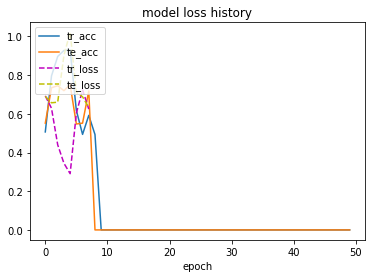

In [101]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'], 'm--')
plt.plot(hist.history['val_loss'], 'y--')
plt.title('model loss history')
plt.xlabel('epoch')
plt.legend(['tr_acc', 'te_acc','tr_loss', 'te_loss'], loc='upper left')
plt.show()

In [24]:
# x_train, x_test, y_train, y_test = load_data()

In [25]:
# from sklearn.cross_validation import StratifiedKFold

# def train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test)):
#     model.fit...
#     # fit and evaluate here.

# if __name__ == "__main__":
#     n_folds = 10
#     data, labels, header_info = load_data()
#     skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

#     for i, (train, test) in enumerate(skf):
#             print "Running Fold", i+1, "/", n_folds
#             model = None # Clearing the NN.
#             model = create_model()
#             train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])